In [1]:
import boto3
import awswrangler as wr
import pandas as pd
from tqdm import tqdm
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

In [15]:
data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]
sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)
df_dict = {}

after_date = "2023-10-01"
for source in data_sources:
	dfs = []
	print(source)
	for path in tqdm(sources_dict[source]):
		date = path.split("/")[-1].split(".")[0]
		if date < after_date:
			continue
		new_df = wr.s3.read_parquet(path, boto3_session=session)
		new_df["date"] = date
		dfs.append(new_df)

	df_dict[source] = pd.concat(dfs, axis = 0)
joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
joined_df.shape

seekingAlpha.seekingAlphaBulkMetrics


  0%|          | 0/12 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_45596/3729858734.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = date
 25%|██▌       | 3/12 [00:00<00:02,  4.42it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_45596/3729858734.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = date
 33%|███▎      | 4/12 [00:01<00:03,  2.27it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_45596/3729858734.py:14: PerformanceWarning:

gurufocus


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


(15936, 337)

In [16]:
step1_df = joined_df[~joined_df["primary_price"].isna()]
step1_df.shape

(15926, 337)

In [17]:
float_df = step1_df.select_dtypes([int, float])

In [18]:
nan_pct = float_df.isna().sum() / float_df.shape[0]
nan_pct.sort_values(ascending = False)

peg_gaap_avg_5y           0.992779
Price-to-FFO              0.937900
cf_payout_avg_5y          0.934196
impliedmarketcap          0.928984
Price-to-Net-Cash         0.886663
                            ...   
sma_10d                   0.000000
sma_100d                  0.000000
close                     0.000000
last_price_vs_sma_100d    0.000000
Enterprise_Value          0.000000
Length: 335, dtype: float64

In [19]:
(nan_pct > 0.0).sum()

316

In [23]:
nan_pct.describe()

count    335.000000
mean       0.232231
std        0.222074
min        0.000000
25%        0.037486
50%        0.153334
75%        0.416332
max        0.992779
dtype: float64

In [26]:
nan_pct[abs(nan_pct - 0.153334) < 0.01]

assets_turnover_avg_5y        0.157353
gross_margin_avg_5y           0.157353
momentum_12m_avg_5y           0.153334
momentum_9m_avg_5y            0.143853
op_cf_yoy_avg_5y              0.145360
oper_income_fy1_market_cap    0.151450
roe_yoy_avg_5y                0.161811
Days_Sales_Outstanding        0.147181
Days_Payable                  0.152267
dtype: float64

Text(0, 0.5, 'Count of Features')

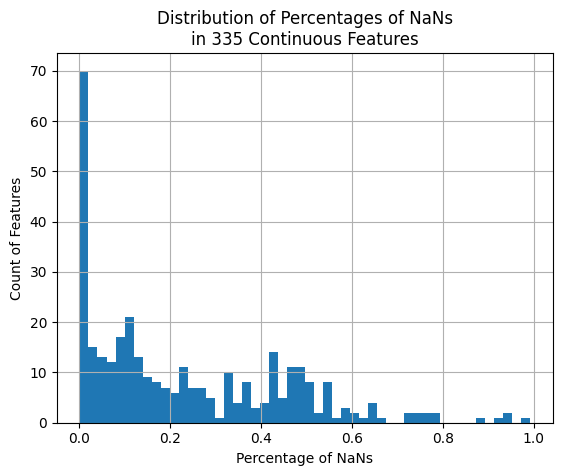

In [21]:
import matplotlib.pyplot as plt
nan_pct.hist(bins=50)
plt.title("Distribution of Percentages of NaNs\nin 335 Continuous Features")
plt.xlabel("Percentage of NaNs")
plt.ylabel("Count of Features")

In [22]:
nan_pct[nan_pct == 0.0].shape

(19,)

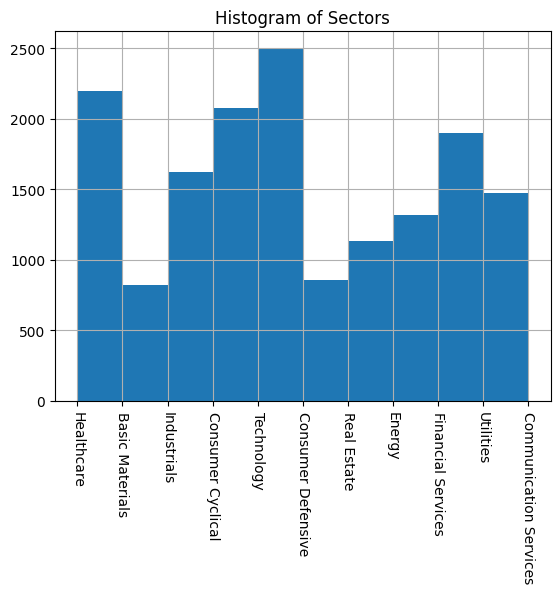

In [8]:
import matplotlib.pyplot as plt
step1_df["sector"].hist()
plt.title("Histogram of Sectors")
plt.xticks(rotation = -90)
pass